In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras import regularizers




In [2]:
sub = pd.read_csv("./opticalflowdata/subway_optical.csv")
danger1 = pd.read_csv("./opticalflowdata/danger1_opt.csv")
japan = pd.read_csv("./opticalflowdata/japan_opt.csv")
japan2 = pd.read_csv("./opticalflowdata/japan2_opt.csv")
bus = pd.read_csv("./opticalflowdata/bus_optical.csv")
sub['label']=0
danger1['label']=1
japan['label']=0
japan2['label']=0
bus['label']=0

In [3]:
sub

,Unnamed: 0,Time,Velocity,Direction,Magnitude,label
0,0,0.0,0.265570,4.227153,2.796313,0
1,1,0.1,0.300980,3.628604,4.147896,0
2,2,0.2,0.171430,2.784595,4.383317,0
3,3,0.3,0.319400,3.400146,3.691183,0
4,4,0.4,0.216679,3.591772,4.378738,0
...,...,...,...,...,...,...
4521,4521,452.1,0.030972,2.313692,3.357823,0
4522,4522,452.2,0.021776,3.944204,3.463625,0
4523,4523,452.3,0.114577,2.494991,4.947088,0
4524,4524,452.4,0.058680,2.492318,3.403044,0


In [4]:
combined_data = pd.concat([sub, danger1, japan, japan2, bus], axis=0)

In [5]:
all_data = combined_data[['Velocity','Direction','label']]

In [6]:
all_data.to_csv('./anomaly_dataset.csv',index=False)

In [7]:
all_data

,Velocity,Direction,label
0,0.265570,4.227153,0
1,0.300980,3.628604,0
2,0.171430,2.784595,0
3,0.319400,3.400146,0
4,0.216679,3.591772,0
...,...,...,...
6533,0.231716,2.996458,0
6534,0.118288,3.533865,0
6535,0.160724,3.785585,0
6536,0.130927,3.427468,0


In [10]:
abnor = all_data[all_data['label']==1]

In [11]:
nor = all_data[all_data['label']==0]

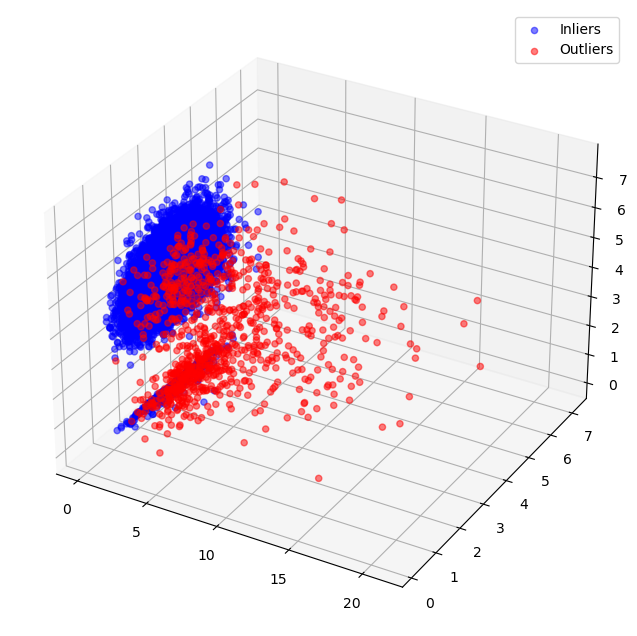

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), subplot_kw={'projection': '3d'})
axes.scatter(nor['Velocity'], nor['Direction'], nor['Magnitude'],
                    label='Inliers', color='blue', marker='o', alpha=0.5)
axes.scatter(abnor['Velocity'], abnor['Direction'],abnor['Magnitude'],
                    label='Outliers', color='red', marker='o', alpha=0.5)

plt.legend()
plt.show()

In [33]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9545628037318938529
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1734816564
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12347170225618995717
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [51]:
class SVDD(tf.keras.models.Model):
    def __init__(self, output_dim, init_c):
        super(SVDD, self).__init__()
        self.output_dim = output_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(12, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(4, activation='relu'),
            tf.keras.layers.Dense(output_dim, activation='sigmoid')
        ])
        self.init_c = init_c
        self.c = tf.Variable(initial_value= self.init_c, trainable=True, dtype='float32')
        
    def call(self, inputs):
        x = self.encoder(inputs)
        c = self.c
        distance = tf.reduce_sum(tf.square(x -c), axis=-1)
        return distance
    
    def compute_R(self, X_in):
        self.R = np.max(np.linalg.norm(self.encoder(X_in) - self.c, axis=1))

In [52]:
# 데이터 생성

X,y = all_data[['Velocity','Direction','Magnitude']].values,all_data['label']

X_in = X[y==0]  # inlier 데이터
X_out = X[y==1] # outlier 데이터





Epoch 1/100
1068/1068 [==============================] - 7s 4ms/step - loss: 0.0482
Epoch 2/100
1068/1068 [==============================] - 4s 4ms/step - loss: 1.1483e-04
Epoch 3/100
1068/1068 [==============================] - 4s 4ms/step - loss: 3.2757e-05
Epoch 4/100
1068/1068 [==============================] - 3s 3ms/step - loss: 1.1429e-05
Epoch 5/100
1068/1068 [==============================] - 4s 3ms/step - loss: 4.5117e-06
Epoch 6/100
1068/1068 [==============================] - 3s 3ms/step - loss: 1.9579e-06
Epoch 7/100
1068/1068 [==============================] - 3s 3ms/step - loss: 9.2024e-07
Epoch 8/100
1068/1068 [==============================] - 3s 3ms/step - loss: 4.6192e-07
Epoch 9/100
1068/1068 [==============================] - 4s 4ms/step - loss: 2.4725e-07
Epoch 10/100
1068/1068 [==============================] - 4s 3ms/step - loss: 1.4575e-07
Epoch 11/100
1068/1068 [==============================] - 4s 4ms/step - loss: 9.1908e-08
Epoch 12/100
1068/1068 [==========

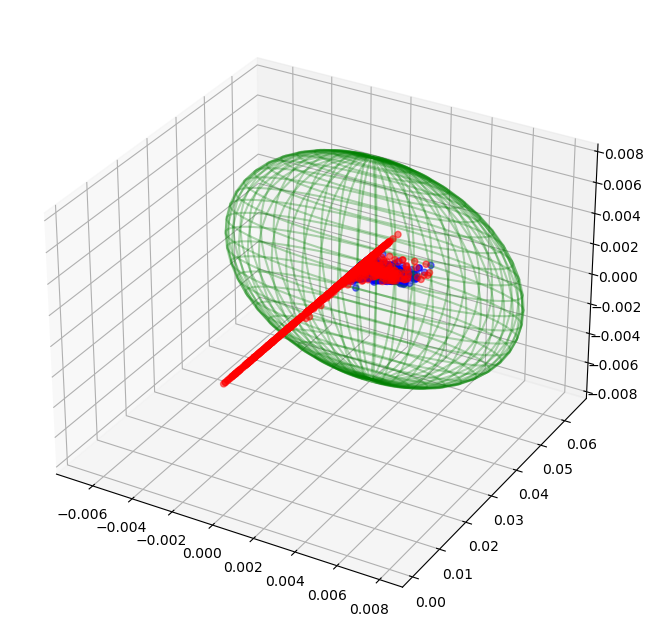

In [53]:
output_dim = 3  # encoder 모델 출력 차원

# 데이터 전처리
scaler = StandardScaler()
scaler.fit(X)
X_in = scaler.transform(X_in)
X_out = scaler.transform(X_out)


# 초기 중심의 좌표
init_center = np.mean(X_in , axis = 0)


# SVDD 모델 학습
svdd_model = SVDD(output_dim, init_center)
svdd_model.compile(loss='mse', optimizer='adam')

with tf.device("/gpu:0"):
    svdd_model.fit(X_in, y[y==0], epochs=100, batch_size=16)

# 반지름 계산
svdd_model.compute_R(X_in)


# draw sphere
center = svdd_model.c.numpy()
radius = svdd_model.R

print(init_center)
print("중심점:", center)
print("반지름:", radius)



# 구를 구성하는 점들의 각도
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 25)

# 구를 구성하는 점들의 좌표 계산
x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

# 구 그리기
v1 = np.array(svdd_model.encoder(X_in))
v2 = np.array(svdd_model.encoder(X_out))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), subplot_kw={'projection': '3d'})

axes.scatter(v1[:, 0], v1[:, 1], v1[:, 2],
                    label='Inliers', color='blue', marker='o', alpha=0.5)

axes.scatter(v2[:, 0], v2[:, 1], v2[:, 2],
                    label='Outliers', color='red', marker='o', alpha=0.5)
axes.plot_wireframe(x, y, z, color='green', alpha=0.3)

NameError: name 'results' is not defined